### **Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import wandb

## **Downloading Data**

In [4]:
from keras.datasets import fashion_mnist

In [5]:
fashion_mnist

<module 'keras.datasets.fashion_mnist' from '/usr/local/lib/python3.9/dist-packages/keras/datasets/fashion_mnist.py'>

## **Data pre-processing**

In [6]:
# Split the data into training and testing
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# Print the dimensions of the dataset
print('Train: X = ', trainX.shape)
print('Test: X = ', testX.shape)


Train: X =  (60000, 28, 28)
Test: X =  (10000, 28, 28)


In [7]:
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

### **Q1**

---



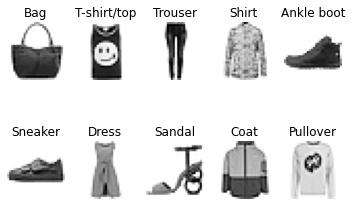

In [8]:
j=0 #j corresponds to the spot index in the subplot 
classSet=set()
Images=[]
for i in range(100,150):#i corresponds to the img index 
  if(j>9):
    break
  if(trainY[i] not in classSet):
    classSet.add(trainY[i])
    Images.append(wandb.Image(trainX[i], caption=class_labels[trainY[i]]))
    plt.subplot(2,5,j+1);j+=1
    plt.imshow(trainX[i], cmap="Greys")
    plt.axis('off') # off the axis
    plt.title('{}'.format(class_labels[trainY[i]]))

In [9]:
wandb.init(project="project4")

wandb: Currently logged in as: cs22m008. Use `wandb login --relogin` to force relogin


In [10]:
wandb.log({"Examples for each class": Images})


### **Q2**

---


## **Data Preprocessing**

In [11]:
trainX = trainX.reshape(trainX.shape[0], 784)
testX = testX.reshape(testX.shape[0], 784)

In [12]:
#feature Scaling
trainX=trainX/255.0
testX=testX/255.0

print(trainX.shape)
print(testX.shape)

(60000, 784)
(10000, 784)


In [13]:
# Split the X_train into a training set and validation set
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.1, random_state=100)


In [14]:

print(trainX.shape)
print(testX.shape)
print(valX.shape)

(54000, 784)
(10000, 784)
(6000, 784)


In [15]:
print(trainY.shape)
print(testY.shape)
print(valY.shape)

(54000,)
(10000,)
(6000,)


## **Functions**

In [16]:
def sigmoid(a):
    return 1.0 / (np.exp(-a)+1.0)

def softmax(a):
    return np.exp(a)/np.sum(np.exp(a),axis=0)

def grad_softmax(x):
    return softmax(x) * (1-softmax(x))

def grad_sigmoid(a):
  return sigmoid(a)*(1-sigmoid(a))

def relu(x):
    return np.maximum(0,x)

def grad_relu(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def grad_tanh(x):
    return (1 - (np.tanh(x)**2))

def identity(x):
  return x

def grad_identity(x):
  return np.ones(x.shape)

### **Q3**



In [17]:
numSamples=trainX.shape[0]
numSamples

54000

### **Model**

In [31]:
class model():
  def __init__(self,numLayers,numNeurons,optimizer,activation_funtion,initialization,l2_lambda): 
    self.numLayers=numLayers #3 hidden layers
    self.numHiddenLayers=self.numLayers-1
    self.numNeurons=numNeurons
    self.numClasses=10
    self.grad_w=[]
    self.grad_b=[]
    self.y_pred=[]
    self.u_w=0
    self.u_b=0
    self.m_w=0
    self.m_b=0
    self.W_L=[]
    self.b_L=[]
    self.optimizer=optimizer
    if(activation_funtion=="sigmoid"):
      self.g=sigmoid
      self.grad_activation=grad_sigmoid
    if(activation_funtion=="relu"):
      self.g=relu
      self.grad_activation=grad_relu
    if(activation_funtion=="tanh"):
      self.g=tanh
      self.grad_activation=grad_tanh
    self.initialization=initialization
    self.l2_lambda=l2_lambda
      

  def initialize(self):
    #Initialising weights and Biases
    if self.initialization=="random_uniform":
      W = []
      W.append((np.random.uniform(-1,1,(784,self.numNeurons))))
      for i in range (2 , self.numHiddenLayers+1): #Hiddenlayer 1 to last hidden layer (starts from 2 coz first layer is init just above)
        W.append((np.random.uniform(-1,1,(self.numNeurons,self.numNeurons))))
      W.append((np.random.uniform(-1,1,(self.numNeurons,self.numClasses))))
      self.W= np.array(W)

    if self.initialization=="Xavier":
      W = []
      W.append((np.random.uniform(-1,1,(784,self.numNeurons)))*np.sqrt(2/(784+self.numNeurons)))
      for i in range (2 , self.numHiddenLayers+1): #Hiddenlayer 1 to last hidden layer (starts from 2 coz first layer is init just above)
        W.append((np.random.uniform(-1,1,(self.numNeurons,self.numNeurons)))*np.sqrt(2/(self.numNeurons+self.numNeurons)))
      W.append((np.random.uniform(-1,1,(self.numNeurons,self.numClasses)))*np.sqrt(2/(self.numNeurons+self.numClasses)))
      self.W= np.array(W)

    b = []
    for i in range (1 , self.numLayers): #Hiddenlayer1 to last hidden layer
      b.append(np.zeros((self.numNeurons,1)))
    b.append(np.zeros((self.numClasses,1)))
    self.b= np.array(b)

  def back_propagation(self,Y,batch_size,loss):
    grad_a=[None]*(self.numLayers)
    grad_b=[None]*(self.numLayers)
    grad_h=[None]*(self.numLayers)
    grad_w=[None]*(self.numLayers)
    oneHot_y=self.compute_oneHot_y(Y)

    h=self.activation
    a=self.preActivation
    W=self.W

    if loss=="crossEntropy":
      grad_a[self.numLayers-1]=self.y_pred-oneHot_y.T #k-dim
    elif loss=="mse":
      grad_a[self.numLayers-1]=(self.y_pred-oneHot_y.T)*grad_softmax(a[self.numLayers-1])

   
    for k in range (self.numLayers-1,-1,-1): #reverse loop
      grad_w[k]=np.matmul(grad_a[k], h[k].T)+self.l2_lambda*W[k].T
      grad_b[k]=np.sum(grad_a[k],axis=1,keepdims=True)/batch_size++self.l2_lambda*self.b[k]
      grad_h[k]=np.matmul(W[k],grad_a[k])

      if(k>0):
        grad_a[k-1] =grad_h[k] * self.grad_activation(a[k-1])
    self.grad_b,self.grad_w=grad_b,grad_w

  def feed_forward(self,X):
    a=[None]*(self.numLayers)
    h=[None]*(self.numLayers)
    k=0
    h[0]=X.T
    for k in range(0, self.numLayers-1): #for all layers
      a_k=self.b[k]+np.matmul(self.W[k].T,h[k]) #0-based Indexing
      h_k=self.g(a_k)
      a[k]=(a_k)
      h[k+1]=(h_k)
    a[self.numLayers-1]=self.b[self.numLayers-1]+np.matmul(self.W[self.numLayers-1].T,h[self.numLayers-1])

   
    output=softmax(a[self.numLayers-1])
    

    self.activation,self.preActivation=h,a
    self.y_pred=output

  def train(self,trainX,trainY,valX, valY, batch_size,epochs,beta,beta_1,beta_2,neta,t,loss):
    self.initialize()

    if self.optimizer=='nesterov':
      self.init_nag()
    epoch_train_loss=[]
    epoch_val_loss=[]

    for j in range(0,epochs):
      for i in range(0, trainX.shape[0],batch_size):
       
        if (self.optimizer == 'nesterov'):
          W_copy=self.W
          b_copy=self.b
          self.pre_update_nag(neta)


        self.feed_forward(trainX[i:i+batch_size])
        self.back_propagation(trainY[i:i+batch_size],batch_size,loss)
        Grad_w=np.array(self.grad_w)
        for i in range(0,Grad_w.shape[0]):
          Grad_w[i]=Grad_w[i].T
        Grad_b=np.array(self.grad_b)

        if (self.optimizer == 'sgd'):
          self.update_sgd(neta,Grad_w,Grad_b)
        if (self.optimizer == 'momentum'): 
          self.update_mom(neta,beta,Grad_w,Grad_b)
        if (self.optimizer == 'nesterov'):
          self.update_nag(neta,beta,Grad_w,Grad_b,W_copy,b_copy)
        if (self.optimizer == 'rmsprop'):
          self.update_rmsprop(neta,beta,Grad_w,Grad_b)
        if (self.optimizer == 'adam'):
          self.update_adam(neta,beta_1,beta_2,Grad_w,Grad_b,t)
        if (self.optimizer == 'nadam'):
          self.update_nadam(neta,beta_1,beta_2,Grad_w,Grad_b,t)

        #self.update_new_optimiser()     The new optimiser algorithm will be called here
        t+=1

      self.feed_forward(trainX)
      train_acc=self.get_accuracy(trainY,self.y_pred.T)*100
      print("train accuracy: ",train_acc)
      wandb.log({"train_accuracy ": train_acc})

      train_loss=self.compute_loss(self.y_pred,self.compute_oneHot_y(trainY),trainX.shape[0],loss)


      val_loss, val_accuracy=self.test( valX, valY, beta, neta,loss)



      #loss is computed over the entire Xtrain (excluding valX).
      wandb.log({"Training loss ": train_loss} )
      print("Epoch number: ", j, "\tTraining loss:", train_loss)
      epoch_train_loss.append(train_loss)
      epoch_val_loss.append(val_loss)


      wandb.log({"epochs ": j})

    plt.plot(list(range(len(epoch_train_loss))), epoch_train_loss, 'r', label="Training loss")
    plt.plot(list(range(len(epoch_val_loss))), epoch_val_loss, 'b', label="val loss")

    plt.title("Training Loss and Valdation loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()


  def test(self,valX,valY,beta,neta,loss):
    self.feed_forward(valX)

    val_loss=self.compute_loss(self.y_pred,self.compute_oneHot_y(valY),valX.shape[0],loss)

    val_accuracy=self.get_accuracy(valY,self.y_pred.T)*100
    print("val accuracy: ", val_accuracy, "\t val loss:", val_loss)
    wandb.log({"val_accuracy": val_accuracy, "val_loss":val_loss})
    return val_loss, val_accuracy


  def update_sgd(self,neta,Grad_w,Grad_b):
        self.W=self.W-neta*Grad_w
        self.b=self.b-neta*Grad_b
  
  def update_mom(self,neta,beta,Grad_w,Grad_b):
        self.u_w=beta*self.u_w+(1-beta)*Grad_w
        self.u_b=beta*self.u_b+(1-beta)*Grad_b
        self.W=self.W-neta*self.u_w
        self.b=self.b-neta*self.u_b
  
  def update_nag(self,neta,beta,Grad_w,Grad_b,W_copy,b_copy):
        self.W=W_copy
        self.b=b_copy
        self.u_w=beta*self.u_w+(1-beta)*Grad_w
        self.u_b=beta*self.u_b+(1-beta)*Grad_b
        self.W=self.W-neta*self.u_w
        self.b=self.b-neta*self.u_b


  def init_nag(self):
    W_L = []
    W_L.append((np.zeros([784,self.numNeurons])))
    for i in range (2 , self.numHiddenLayers+1): #Hiddenlayer 1 to last hidden layer (starts from 2 coz first layer is init just above)
      W_L.append((np.zeros([self.numNeurons,self.numNeurons])))
    W_L.append((np.zeros([self.numNeurons,self.numClasses])))
    W_L= np.array(W_L)

    b_L = []
    for i in range (1 , self.numLayers): #Hiddenlayer1 to last hidden layer
      b_L.append(np.zeros((self.numNeurons,1)))
    b_L.append(np.zeros((self.numClasses,1)))
    b_L= np.array(b_L)
    self.W_L=W_L
    self.b_L=b_L

  def pre_update_nag(self,neta):
    self.W_L=self.W-neta*self.u_w
    self.b_L=self.b-neta*self.u_b
    self.W=self.W_L
    self.b=self.b_L

  def update_rmsprop(self,neta,beta,Grad_w,Grad_b):
        self.u_w=beta*self.u_w+(1-beta)*Grad_w*Grad_w
        self.u_b=beta*self.u_b+(1-beta)*Grad_b*Grad_b
        self.W=self.W-(neta/(self.u_w**0.5+10**-8))*Grad_w
        self.b=self.b-(neta/(self.u_b**0.5+10**-8))*Grad_b
  
  def update_adam(self,neta,beta_1,beta_2,Grad_w,Grad_b,t):

        self.m_w=beta_1*self.m_w+(1-beta_1)*Grad_w
        self.m_b=beta_1*self.m_b+(1-beta_1)*Grad_b

        self.u_w=beta_2*self.u_w+(1-beta_2)*Grad_w*Grad_w
        self.u_b=beta_2*self.u_b+(1-beta_2)*Grad_b*Grad_b

        m_w_hat=self.m_w/(1-beta_1**t)
        m_b_hat=self.m_b/(1-beta_1**t)

        self.W=self.W-(neta/(self.u_w**0.5+10**-8))*m_w_hat
        self.b=self.b-(neta/(self.u_b**0.5+10**-8))*m_b_hat

  def update_nadam(self,neta,beta_1,beta_2,Grad_w,Grad_b,t):

        self.m_w=beta_1*self.m_w+(1-beta_1)*Grad_w
        self.m_b=beta_1*self.m_b+(1-beta_1)*Grad_b

        self.u_w=beta_2*self.u_w+(1-beta_2)*Grad_w*Grad_w
        self.u_b=beta_2*self.u_b+(1-beta_2)*Grad_b*Grad_b

        m_w_hat=self.m_w/(1-beta_1**t)
        m_b_hat=self.m_b/(1-beta_1**t)

        self.W=self.W-(neta/(self.u_w**0.5+10**-8))*(beta_1*m_w_hat+((1-beta_1)*Grad_w)/(1-beta_1**t))
        self.b=self.b-(neta/(self.u_b**0.5+10**-8))*(beta_1*m_b_hat+((1-beta_1)*Grad_b)/(1-beta_1**t))

  """"def update_new_optimiser(): 
        Update function for a new optimisation algorithm to be entered here """

  def compute_oneHot_y(self,Y):
    oneHot_y=[]
    for i in range(0,Y.shape[0]):
      temp=np.zeros(self.numClasses)
      temp[Y[i]]=1
      oneHot_y.append(temp)
    oneHot_y=np.array(oneHot_y)
    return oneHot_y

  def compute_loss(self,y_pred,oneHot_y,numImages,loss):

    loss_reg=0
    for i in range(0, 4):
        loss_reg += np.sum(np.square(np.linalg.norm(self.W[i])))
        loss_reg += np.sum(np.square(np.linalg.norm(self.b[i])))
    if loss == 'crossEntropy':
        return (-1.0 * np.sum(np.multiply(oneHot_y.T, np.log(y_pred)))/numImages + (self.l2_lambda*loss_reg/2))

    elif loss == 'mse':
        return  ((1/2) * np.sum((oneHot_y.T-y_pred)**2)/numImages + (self.l2_lambda*loss_reg/numImages))


  def get_accuracy(self,Y_true,Y_pred):
    size=Y_true.shape[0]
    corrects = 0
    s=0
    while(s<size):
      t=0
      maxT = 0
      maxS = 0

      while (t<10):
        if (maxS < Y_pred[s][t]):
          maxT = t
          maxS = Y_pred[s][t]
        t+=1
      if (maxT == Y_true[s]):
        corrects+=1
      accuracy=corrects/size
      s+=1
    return accuracy



In [26]:
sweep_config = {
  "name": "CS6910 Assignment 1",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "bayes",
  "parameters": {
       "activation_funtion": {
            "values": ["sigmoid", "tanh", "relu"]
        },
        "initialization": {
            "values": ["Xavier", "random_uniform"]
        },
        "learning_rate": {
            "values": [1e-3, 1e-4]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nesterov", "adam", "nadam", "rmsprop"]
        },
        "batch_size": {
            "values": [16, 32, 64]
        },
        "epochs": {
            "values": [5, 10]
        },
        "l2_lambda": {
            "values": [0, 0.0005, 0.5]
        },
         "numLayers": {
            "values": [4, 5, 6] #numHiddenLayers=numLayers-1  Hence, numHiddenLayers: [3, 4, 5]
        },

        "numNeurons": {
            "values": [32, 64, 128]
        }
    }
}

In [27]:
def sweep():
  wandb.init()
  config = wandb.config
  obj = model(config.numLayers,config.numNeurons,config.optimizer,config.activation_funtion,config.initialization,config.l2_lambda)

  beta=0.999
  beta_1=0.9
  beta_2=0.999

  t = 1 # initialize timestep for Adam optimizer
  loss="mse"
  obj.train(trainX,trainY,valX, valY, config.batch_size,config.epochs,beta,beta_1,beta_2,config.learning_rate,t,loss)

  #there is no back_prop in test.. so need not actually give beta, beta_1, neta, t etc..!
  # obj.test(testX,testY,beta,config.learning_rate)
  run_name = "lr_{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(config.learning_rate, config.activation_funtion,config.initialization, config.optimizer, config.batch_size, config.l2_lambda, config.epochs, config.numNeurons, config.numLayers-1)
  print(run_name)
  wandb.run.name = run_name
  wandb.run.save()

<ipython-input-25-fd9094387bf5>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.W= np.array(W)
<ipython-input-25-fd9094387bf5>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.b= np.array(b)
<ipython-input-25-fd9094387bf5>:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Grad_w=np.array(self.grad_w)
<ipython-input-25-

train accuracy:  84.22777777777777
val accuracy:  83.86666666666667 	 val loss: 0.436532249808976
Epoch number:  0 	Training loss: 0.427764441422567
train accuracy:  86.52037037037037
val accuracy:  85.7 	 val loss: 0.3845078830133964
Epoch number:  1 	Training loss: 0.373694010475319
train accuracy:  87.53703703703704
val accuracy:  86.76666666666667 	 val loss: 0.363978479727612
Epoch number:  2 	Training loss: 0.3452734408890045
train accuracy:  88.2
val accuracy:  87.13333333333333 	 val loss: 0.35028846365545163
Epoch number:  3 	Training loss: 0.3252823448603271
train accuracy:  88.75925925925927
val accuracy:  87.86666666666667 	 val loss: 0.3419480425121099
Epoch number:  4 	Training loss: 0.3116829054006308
train accuracy:  88.79629629629629
val accuracy:  87.76666666666667 	 val loss: 0.34126149592626104
Epoch number:  5 	Training loss: 0.3082287386533163
train accuracy:  89.3462962962963
val accuracy:  88.16666666666667 	 val loss: 0.3290578221578266
Epoch number:  6 	Traini

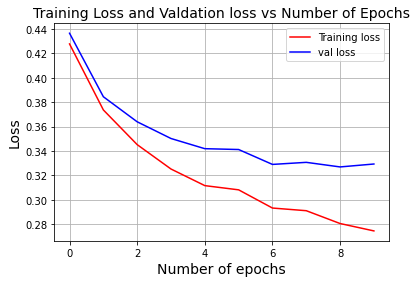

In [28]:
beta=0.999
beta_1=0.9
beta_2=0.999
obj=model(3+1,128,"adam","tanh","Xavier",0)
  # def train(trainX,trainY,valX, valY, batch_size,epochs,beta,beta_1,beta_2,neta,t,loss):

obj.train(trainX,trainY, valX,valY ,64, 10 ,beta,beta_1,beta_2,0.001,1,"crossEntropy")

In [22]:
# sweep_id = wandb.sweep(sweep_config,project="Project 14 revert mse")
# wandb.agent(sweep_id, sweep, count=10)

IndexError: ignored